## imports

In [ ]:
import neurokit2 as nk
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt 
import xgboost as xgb
import seaborn as sns
import shap
import scipy.stats as stats
from datetime import datetime, timedelta
import re
from scipy.stats import linregress, ttest_rel, wilcoxon, zscore
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from tqdm import tqdm
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.regression.mixed_linear_model import MixedLM
from xlogit import MixedLogit as xl
import matplotlib.patches as mpatches
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import GroupKFold
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import RidgeClassifier
from lightgbm import LGBMClassifier



warnings.filterwarnings("ignore", category=UserWarning)
xgb.set_config(verbosity=0)  # Suppresses XGBoost warnings

# Specify the path to the desired directory
parent_dir = r'SET WORKING DIRECTORY HERE'

# Change the current working directory to the specified directory
os.chdir(parent_dir)

all_ratings_BEWSFB = pd.read_csv("SET RATINGS+FEATURES FILE HRE", sep=",")

# Verify that the working directory has been changed
print("Current working directory:", os.getcwd())

C:\Users\BootMR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current working directory: C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER


## new classifc 5-2

In [7]:
# Rename original columns by adding "_original" suffix
all_ratings_BEWSFB.rename(columns={
    "sociodem_age": "sociodem_age_original",
    "sociodem_gender": "sociodem_gender_original"
}, inplace=True)

# Define mapping dictionaries
age_mapping = {
    '<25': 20,
    '25-35': 30,
    '36-45': 40,
    '46-55': 50,
    '56-65': 60,
    '66-75': 70,
    '75<': 75
}

gender_mapping = {
    'Female': 0,
    'Male': 1
}

# Apply mappings to create new columns
all_ratings_BEWSFB["sociodem_age"] = all_ratings_BEWSFB["sociodem_age_original"].map(age_mapping)
all_ratings_BEWSFB["sociodem_gender"] = all_ratings_BEWSFB["sociodem_gender_original"].map(gender_mapping)


In [ ]:



hrv_features = [
    'H10_hr_mean', 'H10_hr_stdev', 'H10_hrv_mean', 'H10_hrv_stdev', 'H10_HRV_MeanNN', 'H10_HRV_RMSSD', 'H10_HRV_LF', 'H10_HRV_HF', 'H10_HRV_LFHF'
]

eda_features = [
    'E4_eda_tonic_mean', 'E4_eda_tonic_std', 'E4_eda_tonic_peaks', 'E4_eda_phasic_mean', 'E4_eda_phasic_std', 'E4_eda_phasic_peaks'
]

selected_features = [
    'p_id', 'rating_totalperpid', 
    
    'H10_hr_mean', 'H10_hrv_mean', 'H10_HRV_RMSSD', 'H10_HRV_MeanNN', 'H10_HRV_HF',
    
    'E4_eda_phasic_mean', 'E4_eda_phasic_peaks', 'E4_eda_phasic_max', 'E4_eda_phasic_n_above_mean', 'E4_eda_tonic_mean', 'E4_eda_tonic_peaks', 'E4_eda_tonic_n_above_mean', 
    
    'cadence_avg', 'velocity_avg', 'velocity_avg_change', 
    
    'warnings_slowdown_count', 'warnings_tactile_warning', 'warnings_audio_warning', 'warnings_warning_value', 
    
    'sociodem_age', 'sociodem_gender', 'sociodem_income', 'sociodem_education', 'sociodem_cycling_experience', 'sociodem_BMI', 'sociodem_fitness', 'sociodem_mood', 'sociodem_pleasantness_disposition', 
    
    'context_surface_type', 'context_road_quality', 'context_scenic_beauty', 'context_hindrance', 'context_road_type', 'weather_temperature', 'weather_wind_speed', 'context_perceivedinfluence', 'cycling_perceivedintensity'
]

extended_features = [
    #everything from selected
    'p_id', 'rating_totalperpid', 
    
    'H10_hr_mean', 'H10_hr_stdev', 'H10_hrv_mean', 'H10_hrv_stdev', 'H10_HRV_MeanNN', 'H10_HRV_RMSSD', 'H10_HRV_LF', 'H10_HRV_HF', 'H10_HRV_LFHF', 
    
    'E4_eda_tonic_mean', 'E4_eda_tonic_std', 'E4_eda_tonic_peaks', 'E4_eda_phasic_mean', 'E4_eda_phasic_std', 'E4_eda_phasic_peaks', 
    
    'cadence_avg', 'velocity_avg', 'velocity_avg_change', 
    
    'warnings_slowdown_count', 'warnings_tactile_warning', 'warnings_audio_warning', 'warnings_warning_value', 
    
    'sociodem_age','sociodem_income', 'sociodem_education', 'sociodem_cycling_experience', 'sociodem_BMI', 'sociodem_fitness', 'sociodem_mood', 'sociodem_pleasantness_disposition', 'context_surface_type', 'context_road_quality', 'context_scenic_beauty', 'context_hindrance', 
    
    'context_road_type', 'weather_temperature', 'weather_wind_speed', 'context_perceivedinfluence', 'cycling_perceivedintensity'
     
    #plus: 
    'H10_HRV_LF', 'H10_HRV_LFHF',
    'E4_hrv_rmssd', 'E4_hrv_mean_hr', 'E4_hrv_lf', 'E4_hrv_hf', 'E4_hrv_lf_hf_ratio', 'E4_hrv_std',
    'E4_acc_acc_x_mean', 'E4_acc_acc_x_std', 'E4_acc_acc_x_skewness', 'E4_acc_acc_y_std', 'E4_acc_acc_y_skewness',
    'E4_acc_acc_z_mean', 'E4_acc_acc_z_std', 'E4_acc_acc_z_skewness', 'E4_acc_l2_mean', 'E4_acc_l2_std', 'E4_acc_l2_skewness',
    'cadence_min', 'cadence_max', 'cadence_std', 'cadence_avgacc', 'cadence_slope', 'cadence_cv', 'cadence_skewness', 'cadence_kurtosis',
    'cadence_pvr', 
    'velocity_cv', 'velocity_skewness', 'velocity_kurtosis', 'velocity_slope',
    'humidity', 'cloudiness', 'rain_3h', 'wind_direction',
    'Nationality', 'gender', 'length', 'coffee', 
]

In [19]:
#part 1 - sampling to an evenly balanced dataset

# Step 1: Separate the -1 and 1 ratings
class_neg1 = all_ratings_BEWSFB[all_ratings_BEWSFB["rating"] == -1].copy()
class_pos1 = all_ratings_BEWSFB[all_ratings_BEWSFB["rating"] == 1].copy()

# Step 2: Calculate inverse frequency weights by p_id
# So participants with few ratings get higher weight
rating_counts = all_ratings_BEWSFB.groupby("p_id")["p_id"].transform("count")
all_ratings_BEWSFB["rating_weight"] = 1 / rating_counts

# Step 3: Apply those weights to the 1-class subset only
class_pos1 = class_pos1.copy()
class_pos1["rating_weight"] = 1 / class_pos1.groupby("p_id")["p_id"].transform("count")

# Step 4: Sample 195 positive ratings using the weights
sampled_pos1 = class_pos1.sample(n=195, weights=class_pos1["rating_weight"], random_state=42)

# Step 5: Combine both to create a balanced sampled_df
sampled_df = pd.concat([class_neg1, sampled_pos1], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)


In [20]:
#part 2 - prepare models and featrues

# Encode categorical variables
label_encoders = {}
categorical_columns = sampled_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    sampled_df[col] = le.fit_transform(sampled_df[col].astype(str))
    label_encoders[col] = le

# Define target variables
y_binary = sampled_df.loc[sampled_df['rating'].isin([-1, 1]), 'rating'].map({-1: 0, 1: 1})
y_multiclass = sampled_df['rating'].map({-1: 0, 0: 1, 1: 2})

X_binary = sampled_df.loc[y_binary.index]
X_multiclass = sampled_df.loc[y_multiclass.index]

# Feature sets
feature_sets = {
    'H10 HRV': hrv_features,
    'E4 EDA': eda_features,
    'Selected': selected_features,
    'Extended': extended_features
}

# Hyperparameter grids
param_grids = {
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [None, 10]},
    'SVM (RBF)': {'C': [0.1, 1.0], 'kernel': ['rbf']},
    'XGBoost': {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100]}
}

In [21]:
#part 3 - 



# script part 2 - run model
# now include storing probabilities for RF
# worked well 28-4
# variables (feature_sets, X_binary, y_binary, X_multiclass, y_multiclass, param_grids) defined above

# Simplified: Only Binary Classification

# Store results
results = []
random_forest_probs = []  # Store per-rating probabilities for Random Forest only
true_labels_selected = []
predicted_labels_selected = []
all_model_probs = []

# Total model runs = (Feature sets) * (4 models)
total_iterations = len(feature_sets) * 4
progress_bar = tqdm(total=total_iterations, desc="Total Progress (LOOCV)", unit="iteration")

# Only run binary classification
task = 'Binary'
X_task, y_task = X_binary, y_binary

for feature_set_name, feature_list in feature_sets.items():
    # Filter feature list to those present in the current data
    feature_list = [col for col in feature_list if col in X_task.columns]
    X = X_task[feature_list].copy()

    # Drop 'p_id' if still in features
    if 'p_id' in X.columns:
        X = X.drop(columns=['p_id'])

    groups = X_task['p_id']

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Use Leave-One-Group-Out CV (1 participant per fold)
    unique_groups = np.unique(groups)
    cv = GroupKFold(n_splits=len(unique_groups))

    for model_name in ['Logistic Regression', 'Random Forest', 'SVM (RBF)', 'XGBoost']:
        # Configure model
        if model_name == 'XGBoost':
            base_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
        elif model_name == 'Random Forest':
            base_model = RandomForestClassifier()
        elif model_name == 'SVM (RBF)':
            base_model = SVC(probability=True)
        else:
            base_model = LogisticRegression(max_iter=1000)

        # Wrap in GridSearchCV if hyperparameters are specified
        if model_name in param_grids:
            model = GridSearchCV(base_model, param_grid=param_grids[model_name],
                                 scoring=['accuracy', 'f1_macro', 'f1_weighted'],
                                 refit='f1_weighted', cv=3)
            model.fit(X, y_task)
            best_model = model.best_estimator_
            best_metric = 'accuracy'
        else:
            model = base_model
            best_model = model
            best_metric = 'N/A'

        # Leave-One-Group-Out Cross-Validation
        f1_scores = []

        for train_idx, val_idx in cv.split(X, y_task, groups=groups):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y_task.to_numpy()[train_idx], y_task.to_numpy()[val_idx]

            best_model.fit(X_train, y_train)

            y_pred_proba = best_model.predict_proba(X_val)
            y_pred = best_model.predict(X_val)
            f1 = f1_score(y_val, y_pred, average='weighted')
            f1_scores.append(f1)

            # Store predictions and probabilities for all models
            for prob, true_label, pred_label in zip(y_pred_proba, y_val, y_pred):
                all_model_probs.append({
                    'model name': model_name,
                    'Feature Set': feature_set_name,
                    'evaluation metric': best_metric,
                    'True Label': true_label,
                    'Pred Label': pred_label,
                    'Prob_Class_0': prob[0],
                    'Prob_Class_1': prob[1]
                })

            # Also store for confusion matrix if Random Forest and selected features
            if model_name == 'Random Forest':
                for prob, true_label, pred_label in zip(y_pred_proba, y_val, y_pred):
                    random_forest_probs.append({
                        'Feature Set': feature_set_name,
                        'True Label': true_label,
                        'Pred Label': pred_label,
                        'Prob_Class_0': prob[0],
                        'Prob_Class_1': prob[1]
                    })
                    if feature_set_name == 'selected_features':
                        true_labels_selected.append(true_label)
                        predicted_labels_selected.append(pred_label)

        avg_f1 = np.mean(f1_scores)

        # Store results
        results.append({
            'Feature Set': feature_set_name,
            'Classification Type': task,
            'Model': model_name,
            'F1 Score': avg_f1
        })

        # Update progress bar
        progress_bar.update(1)

progress_bar.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create pivot table for visualization
pivot_f1 = results_df.pivot_table(
    values='F1 Score',
    index=['Feature Set', 'Classification Type'],
    columns='Model'
)

# Copy results to clipboard (optional)
pivot_f1.to_clipboard(excel=True)
print("F1 scores copied to clipboard. Paste (Ctrl+V) into Excel.")

# --- NEW: Plot histogram of Random Forest predicted probabilities ---
random_forest_probs_df = pd.DataFrame(random_forest_probs)
all_model_probs_df_f1_weighted = pd.DataFrame(all_model_probs)


Total Progress (LOOCV): 100%|██████████| 16/16 [01:05<00:00,  4.11s/iteration]

F1 scores copied to clipboard. Paste (Ctrl+V) into Excel.


## SHAP beeswarm plot

LOOCV SHAP: 0it [00:00, ?it/s]

LOOCV SHAP: 28it [00:17,  1.59it/s]


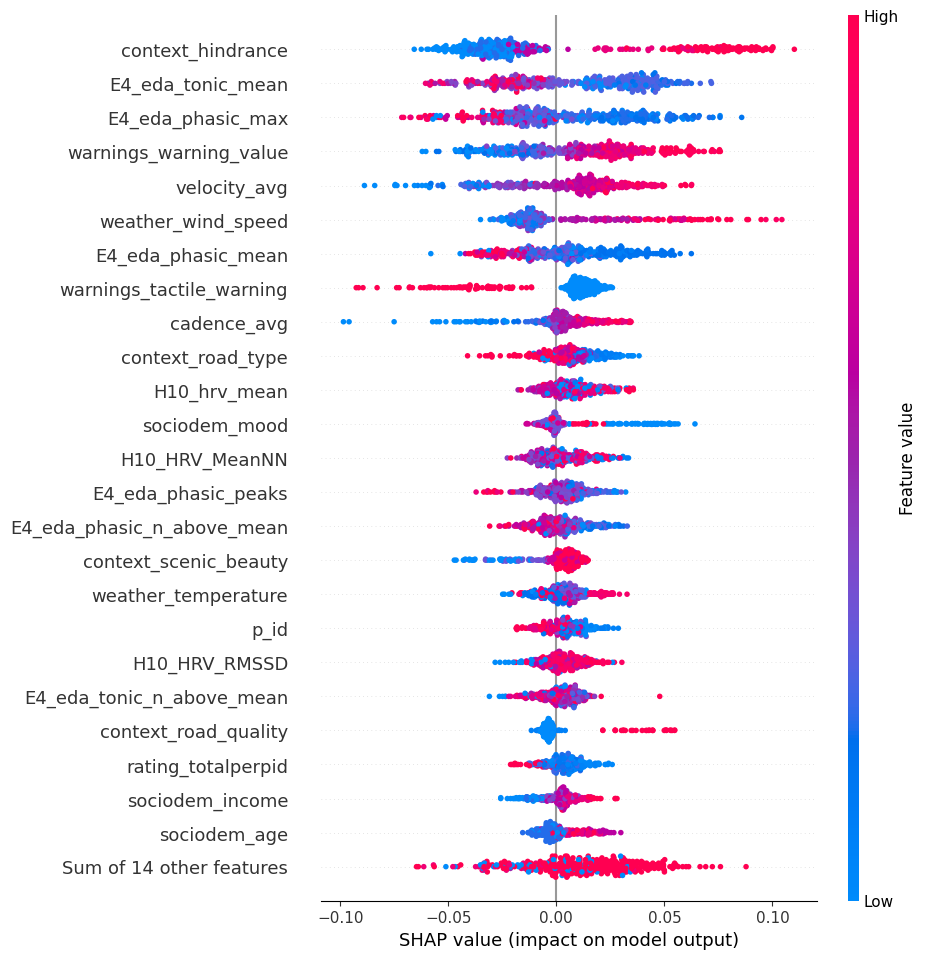

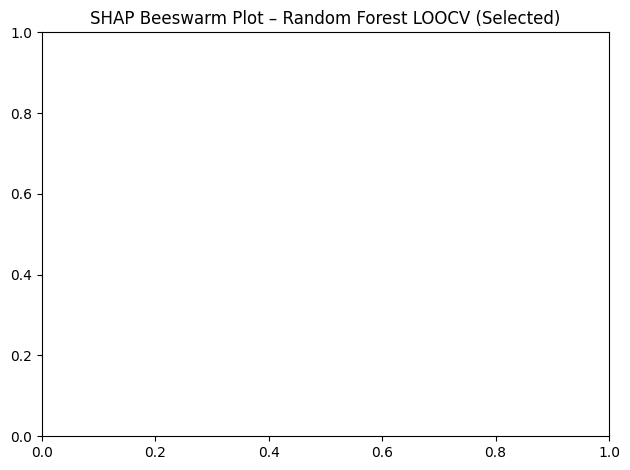

In [32]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# --- Assume X_binary, y_binary, feature_sets are already defined ---

# Target feature set
target_feature_set = 'Selected'
features = [f for f in feature_sets[target_feature_set] if f in X_binary.columns]

# Prepare data
X = X_binary[features].copy()
y = y_binary.copy()
groups = X_binary["p_id"]

imputer = SimpleImputer()
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

rf_model = RandomForestClassifier()

cv = GroupKFold(n_splits=len(np.unique(groups)))

shap_values_all = []
X_val_all = []

for train_idx, val_idx in tqdm(cv.split(X_scaled, y, groups=groups), desc="LOOCV SHAP"):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train = y.iloc[train_idx]

    rf_model.fit(X_train, y_train)

    explainer = shap.Explainer(rf_model, X_train, feature_names=features)
    shap_vals = explainer(X_val, check_additivity=False)

    # Use only class 1 SHAP values (positive class)
    shap_values_all.append(shap_vals.values[:, :, 1])
    X_val_all.append(X_val)

# Stack all SHAP values and input data
shap_values_combined = np.vstack(shap_values_all)
X_val_combined = np.vstack(X_val_all)

# Create SHAP Explanation object for class 1
shap_explanation = shap.Explanation(
    values=shap_values_combined,
    data=X_val_combined,
    feature_names=features
)

# Beeswarm plot
plt.figure(figsize=(12, 6))
shap.plots.beeswarm(shap_explanation, max_display=25)
plt.title(f"SHAP Beeswarm Plot – Random Forest LOOCV ({target_feature_set})")
plt.tight_layout()
plt.show()


## Probability historgrams

In [10]:
# Simplified: Only Binary Classification

from sklearn.base import clone
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import RidgeClassifier
from lightgbm import LGBMClassifier



# Store results
results = []
random_forest_probs = []  # Store per-rating probabilities for Random Forest only
true_labels_selected = []
predicted_labels_selected = []
all_model_probs = []

# Total model runs = (Feature sets) * (7 models)
total_iterations = len(feature_sets) * 7
progress_bar = tqdm(total=total_iterations, desc="Total Progress (LOOCV)", unit="iteration")

# Only run binary classification
task = 'Binary'
X_task, y_task = X_binary, y_binary

for feature_set_name, feature_list in feature_sets.items():
    # Filter feature list to those present in the current data
    feature_list = [col for col in feature_list if col in X_task.columns]
    X = X_task[feature_list].copy()

    # Drop 'p_id' if still in features
    if 'p_id' in X.columns:
        X = X.drop(columns=['p_id'])

    groups = X_task['p_id']

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Use Leave-One-Group-Out CV (1 participant per fold)
    unique_groups = np.unique(groups)
    cv = GroupKFold(n_splits=len(unique_groups))

    for model_name in ['Logistic Regression', 'Random Forest', 'SVM (RBF)', 'XGBoost', 'MLP', 'RidgeClassifier']:
        # Configure model
        if model_name == 'XGBoost':
            base_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
        elif model_name == 'Random Forest':
            base_model = RandomForestClassifier()
        elif model_name == 'SVM (RBF)':
            base_model = SVC(probability=True)
        elif model_name == 'MLP':
            base_model = MLPClassifier(max_iter=1000)
        elif model_name == 'LightGBM':
            base_model = LGBMClassifier()
        elif model_name == 'RidgeClassifier':
            base_model = RidgeClassifier()
        else:
            base_model = LogisticRegression(max_iter=1000)

        # Wrap in GridSearchCV if hyperparameters are specified
        if model_name in param_grids:
            grid = GridSearchCV(base_model, param_grid=param_grids[model_name],
                                scoring=['accuracy', 'f1_macro', 'f1_weighted'],
                                refit='f1_macro', cv=3)
            grid.fit(X, y_task)

            best_index = grid.best_index_
            mean_scores = {
                metric: grid.cv_results_[f'mean_test_{metric}'][best_index]
                for metric in ['accuracy', 'f1_macro', 'f1_weighted']
            }
            best_metric = max(mean_scores, key=mean_scores.get)
            best_model = clone(grid.best_estimator_)
        else:
            best_model = base_model
            best_metric = 'N/A'

        # Leave-One-Group-Out Cross-Validation
        f1_scores = []

        for train_idx, val_idx in cv.split(X, y_task, groups=groups):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y_task.to_numpy()[train_idx], y_task.to_numpy()[val_idx]

            best_model.fit(X_train, y_train)

            # Some models like RidgeClassifier don't have predict_proba
            try:
                y_pred_proba = best_model.predict_proba(X_val)
            except AttributeError:
                decision_vals = best_model.decision_function(X_val)
                prob_class_1 = 1 / (1 + np.exp(-decision_vals))
                y_pred_proba = np.vstack([1 - prob_class_1, prob_class_1]).T

            y_pred = best_model.predict(X_val)
            f1 = f1_score(y_val, y_pred, average='weighted')
            f1_scores.append(f1)

            # Store predictions and probabilities for all models
            for prob, true_label, pred_label in zip(y_pred_proba, y_val, y_pred):
                all_model_probs.append({
                    'model name': model_name,
                    'Feature Set': feature_set_name,
                    'evaluation metric': best_metric,
                    'True Label': true_label,
                    'Pred Label': pred_label,
                    'Prob_Class_0': prob[0],
                    'Prob_Class_1': prob[1]
                })

            # Also store for confusion matrix if Random Forest and selected features
            if model_name == 'Random Forest':
                for prob, true_label, pred_label in zip(y_pred_proba, y_val, y_pred):
                    random_forest_probs.append({
                        'Feature Set': feature_set_name,
                        'True Label': true_label,
                        'Pred Label': pred_label,
                        'Prob_Class_0': prob[0],
                        'Prob_Class_1': prob[1]
                    })
                    if feature_set_name == 'selected_features':
                        true_labels_selected.append(true_label)
                        predicted_labels_selected.append(pred_label)

        avg_f1 = np.mean(f1_scores)

        # Store results
        results.append({
            'Feature Set': feature_set_name,
            'Classification Type': task,
            'Model': model_name,
            'F1 Score': avg_f1
        })

        # Update progress bar
        progress_bar.update(1)

progress_bar.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create pivot table for visualization
pivot_f1 = results_df.pivot_table(
    values='F1 Score',
    index=['Feature Set', 'Classification Type'],
    columns='Model'
)

# Copy results to clipboard (optional)
pivot_f1.to_clipboard(excel=True)
print("F1 scores copied to clipboard. Paste (Ctrl+V) into Excel.")

# --- NEW: Plot histogram of Random Forest predicted probabilities ---
random_forest_probs_df = pd.DataFrame(random_forest_probs)
all_model_probs_df = pd.DataFrame(all_model_probs)

#run 322


NameError: name 'feature_sets' is not defined

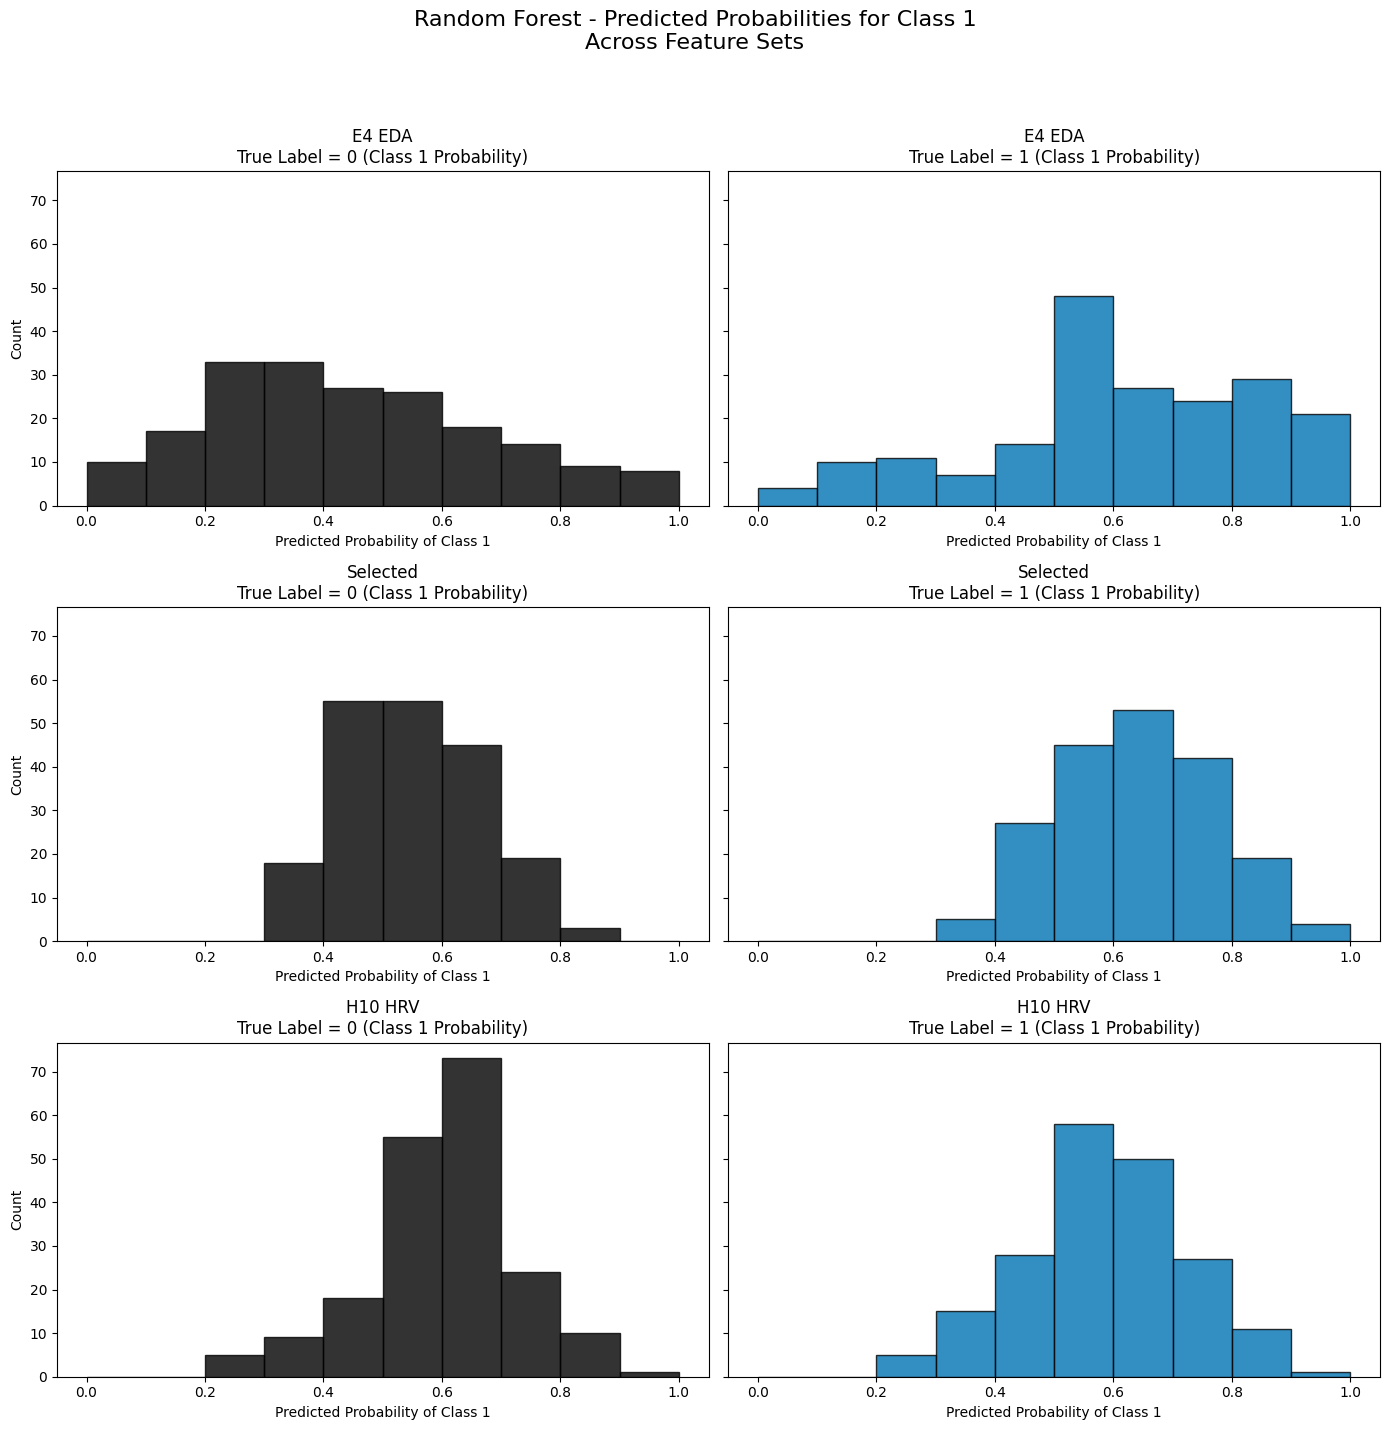

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(14, 15), sharey=True)

feature_sets = ['E4 EDA', 'Selected', 'H10 HRV']

# Define colorblind-friendly colors
color_0 = '#000000'   # Black
color_1 = '#0072B2'   # Blue

for i, fs in enumerate(feature_sets):
    # True Label = 0
    axes[i, 0].hist(
        all_model_probs_df[
            (all_model_probs_df['model name'] == 'Random Forest') &
            (all_model_probs_df['Feature Set'] == fs) &
            (all_model_probs_df['True Label'] == 0)
        ]['Prob_Class_1'],
        bins=np.arange(0, 1.1, 0.1),
        color=color_0, edgecolor='black', alpha=0.8
    )
    axes[i, 0].set_title(f'{fs}\nTrue Label = 0 (Class 1 Probability)')
    axes[i, 0].set_xlabel('Predicted Probability of Class 1')
    axes[i, 0].set_ylabel('Count')

    # True Label = 1
    axes[i, 1].hist(
        all_model_probs_df[
            (all_model_probs_df['model name'] == 'Random Forest') &
            (all_model_probs_df['Feature Set'] == fs) &
            (all_model_probs_df['True Label'] == 1)
        ]['Prob_Class_1'],
        bins=np.arange(0, 1.1, 0.1),
        color=color_1, edgecolor='black', alpha=0.8
    )
    axes[i, 1].set_title(f'{fs}\nTrue Label = 1 (Class 1 Probability)')
    axes[i, 1].set_xlabel('Predicted Probability of Class 1')

plt.suptitle('Random Forest - Predicted Probabilities for Class 1\nAcross Feature Sets', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## classif diff windowlengths

In [29]:




# File paths
merged_files = [
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_30s.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_60s1.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_60s2.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_120s.csv"
]

# File paths
merged_files = [
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_30s.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_60s1.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_60s2.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_120s.csv"
]


# Feature definitions
hrv_features = [
    'hr_mean', 'hr_stdev', 'hrv_mean', 'hrv_stdev',
    'HRV_MeanNN', 'HRV_RMSSD', 'HRV_LF', 'HRV_HF', 'HRV_LFHF'
]

eda_features = [
    'eda_tonic_mean', 'eda_tonic_std', 'eda_tonic_peaks', 'eda_phasic_mean', 'eda_phasic_std', 'eda_phasic_peaks'
]


# Hyperparameter grids
param_grids = {
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [None, 10]},
    'SVM (RBF)': {'C': [0.1, 1.0], 'kernel': ['rbf']},
    'XGBoost': {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100]}
}

# Store results
results = []

for file_path in merged_files:
    print(f"\nProcessing: {file_path}")
    sampled_df = pd.read_csv(file_path)

    #### original sampling

    sampled_df["rating_weight"] = 1 / sampled_df.groupby("p_id")["p_id"].transform("count")
    sample_size = 600
    sampled_df = sampled_df.sample(n=sample_size, weights="rating_weight", random_state=42)

    # Binary classification
    sampled_df = sampled_df[sampled_df['rating'].isin([-1, 1])]
    y_binary = sampled_df['rating'].map({-1: 0, 1: 1})
    groups = sampled_df["p_id"]


    feature_list = [col for col in hrv_features if col in sampled_df.columns]
    if not feature_list:
        print(f"Warning: No HRV features found in {file_path}. Skipping.")
        continue

    X_binary = sampled_df[feature_list]


    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_binary = imputer.fit_transform(X_binary)

    # Feature scaling
    scaler = StandardScaler()
    X_binary = scaler.fit_transform(X_binary)

    # Group-level cross-validation setup (10 folds by participant)
    cv = GroupKFold(n_splits=10)

    for model_name in ['Logistic Regression', 'Random Forest', 'SVM (RBF)', 'XGBoost']:
        print(f"  Training model: {model_name}")

        # Model selection
        if model_name == 'Random Forest':
            model = RandomForestClassifier()
        elif model_name == 'SVM (RBF)':
            model = SVC(probability=True)
        elif model_name == 'XGBoost':
            model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        else:
            model = LogisticRegression(max_iter=1000)

        # Hyperparameter tuning
        if model_name in param_grids:
            grid = GridSearchCV(model, param_grid=param_grids[model_name], scoring='f1_weighted', cv=3)
            grid.fit(X_binary, y_binary)
            best_model = grid.best_estimator_
        else:
            best_model = model

        # Cross-validation evaluation
        f1_scores = []
        conf_matrices = []

        for train_idx, val_idx in cv.split(X_binary, y_binary, groups=groups):
            X_train, X_val = X_binary[train_idx], X_binary[val_idx]
            y_train, y_val = y_binary.to_numpy()[train_idx], y_binary.to_numpy()[val_idx]

            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_val)

            f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
            conf_matrices.append(confusion_matrix(y_val, y_pred))

        avg_f1 = np.mean(f1_scores)
        avg_conf_matrix = np.mean(conf_matrices, axis=0)

        results.append({
            'file': file_path,
            'Feature Set': 'hrv',
            'Model': model_name,
            'F1 Score': avg_f1
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Pivot table for easier visualization in Excel
pivot_f1 = results_df.pivot_table(values='F1 Score', index=['file', 'Feature Set'], columns='Model')

# Copy results to clipboard for Excel
pivot_f1.to_clipboard(excel=True)

print("\nF1 scores copied to clipboard. Paste (Ctrl+V) into Excel.")



Processing: C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_30s.csv
  Training model: Logistic Regression
  Training model: Random Forest
  Training model: SVM (RBF)
  Training model: XGBoost

Processing: C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_60s1.csv
  Training model: Logistic Regression
  Training model: Random Forest
  Training model: SVM (RBF)
  Training model: XGBoost

Processing: C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_60s2.csv
  Training model: Logistic Regression
  Training model: Random Forest
  Training model: SVM (RBF)
  Training model: XGBoost

Processing: C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_120s.csv
  Training model: Logistic Regression
  Training model: Random Forest
  Training model: SVM (RBF)
  Training model: XGBoost

F1 scores copied to clipboard. Paste (Ctrl+V) into E

## descriptive statistics

In [13]:
# Function to print column names in a numbered list
def print_column_names(dataframe):
    columns = dataframe.columns
    for i, column in enumerate(columns, start=1):
        print(f"{column}")

# Print column names for the sample DataFrame
print_column_names(all_ratings_BEWSFB)

p_id
interval_id
rating
rating_totalperpid
latitude
longitude
timestamp_button
timestamp_location
timestamp_flirt
timestamp_timediff_buttonloc
timestamp_window_start_time
timestamp_window_end_time
timestamp_timediff_flirtnk
warnings_slowdown_count
warnings_audio_warning
warnings_tactile_warning
warnings_onoff
warnings_type_text
H10_hr_mean
H10_hr_stdev
H10_hrv_mean
H10_hrv_stdev
H10_HRV_MeanNN
H10_HRV_SDNN
H10_HRV_SDANN1
H10_HRV_SDNNI1
H10_HRV_SDANN2
H10_HRV_SDNNI2
H10_HRV_SDANN5
H10_HRV_SDNNI5
H10_HRV_RMSSD
H10_HRV_SDSD
H10_HRV_CVNN
H10_HRV_CVSD
H10_HRV_MedianNN
H10_HRV_MadNN
H10_HRV_MCVNN
H10_HRV_IQRNN
H10_HRV_SDRMSSD
H10_HRV_Prc20NN
H10_HRV_Prc80NN
H10_HRV_pNN50
H10_HRV_pNN20
H10_HRV_MinNN
H10_HRV_MaxNN
H10_HRV_HTI
H10_HRV_TINN
H10_HRV_ULF
H10_HRV_VLF
H10_HRV_LF
H10_HRV_HF
H10_HRV_VHF
H10_HRV_TP
H10_HRV_LFHF
H10_HRV_LFn
H10_HRV_HFn
H10_HRV_LnHF
H10_HRV_SD1
H10_HRV_SD2
H10_HRV_SD1SD2
H10_HRV_S
H10_HRV_CSI
H10_HRV_CVI
H10_HRV_CSI_Modified
H10_HRV_PIP
H10_HRV_IALS
H10_HRV_PSS
H10_HRV_P

In [3]:
all_baselineHRVfeatures = pd.read_csv("all_baselineHRVfeatures.csv")

In [4]:
all_baselineFlirtfeatures = pd.read_csv("all_baseline_FlirtFeatures_means.csv")

### HR

In [5]:
def compute_hr_table(baseline_df, baseline_hr_col, ratings_df, ratings_hr_col):
    # Compute mean and std for the baseline
    baseline_mean = baseline_df[baseline_hr_col].mean()
    baseline_std = baseline_df[baseline_hr_col].std()

    # Compute mean and std grouped by rating
    stats_by_rating = ratings_df.groupby('rating')[ratings_hr_col].agg(['mean', 'std'])

    # Rename rating categories
    category_names = {-1: 'Unpleasant', 0: 'Neutral', 1: 'Pleasant'}
    stats_by_rating = stats_by_rating.rename(index=category_names)

    # Combine results into a single DataFrame
    results = pd.DataFrame({
        baseline_hr_col: [baseline_mean] + stats_by_rating['mean'].tolist(),
        'std': [baseline_std] + stats_by_rating['std'].tolist()
    }, index=['baseline'] + list(stats_by_rating.index))

    # Format values to one decimal place and replace '.' with ','
    results = results.applymap(lambda x: f"{x:.1f}".replace('.', ','))

    print(results)

In [7]:
# Example usage
compute_hr_table(all_baselineHRVfeatures, 'hr_mean', all_ratings_BEWSFB, 'H10_hr_mean')
print("")
compute_hr_table(all_baselineHRVfeatures, 'hrv_mean', all_ratings_BEWSFB, 'H10_hrv_mean')
print("")
compute_hr_table(all_baselineFlirtfeatures, 'eda_phasic_mean', all_ratings_BEWSFB, 'E4_eda_phasic_mean')
print("")
compute_hr_table(all_baselineFlirtfeatures, 'eda_phasic_peaks', all_ratings_BEWSFB, 'E4_eda_phasic_peaks')
print("")
compute_hr_table(all_baselineFlirtfeatures, 'eda_tonic_mean', all_ratings_BEWSFB, 'E4_eda_tonic_mean')
print("")
compute_hr_table(all_baselineFlirtfeatures, 'eda_tonic_peaks', all_ratings_BEWSFB, 'E4_eda_tonic_peaks')
print("")




#E4_eda_phasic_mean

           hr_mean   std
baseline      83,2  18,4
Unpleasant    37,7  19,6
Neutral       38,6  18,7
Pleasant      36,0  19,8

           hrv_mean     std
baseline      188,3  1084,3
Unpleasant    -52,0   324,3
Neutral       -40,7   342,0
Pleasant      -36,4   277,0

           eda_phasic_mean  std
baseline               0,6  0,8
Unpleasant             1,8  2,6
Neutral                1,7  2,7
Pleasant               1,0  2,0

           eda_phasic_peaks  std
baseline                0,6  0,9
Unpleasant              0,5  1,4
Neutral                 0,4  1,4
Pleasant                0,1  1,0

           eda_tonic_mean  std
baseline              1,9  3,0
Unpleasant            4,2  6,8
Neutral               3,8  5,9
Pleasant              1,9  5,0

           eda_tonic_peaks  std
baseline               0,1  0,2
Unpleasant             0,0  0,3
Neutral                0,0  0,2
Pleasant              -0,0  0,2



C:\Users\BootMR\AppData\Local\Temp\ipykernel_6092\2061521957.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results = results.applymap(lambda x: f"{x:.1f}".replace('.', ','))
C:\Users\BootMR\AppData\Local\Temp\ipykernel_6092\2061521957.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results = results.applymap(lambda x: f"{x:.1f}".replace('.', ','))
C:\Users\BootMR\AppData\Local\Temp\ipykernel_6092\2061521957.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results = results.applymap(lambda x: f"{x:.1f}".replace('.', ','))
C:\Users\BootMR\AppData\Local\Temp\ipykernel_6092\2061521957.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results = results.applymap(lambda x: f"{x:.1f}".replace('.', ','))
C:\Users\BootMR\AppData\Local\Temp\ipykernel_6092\2061521957.py:20: FutureWarning: DataFrame.applymap has been deprecated. U

In [12]:
print("velocity_avg")
print(all_ratings_BEWSFB.groupby('rating')['velocity_avg'].agg(['mean', 'std']))
print("")
print("cadence_avg")
print(all_ratings_BEWSFB.groupby('rating')['cadence_avg'].agg(['mean', 'std']))
print("")
print("temperature")
print(all_ratings_BEWSFB.groupby('rating')['weather_temperature'].agg(['mean', 'std']))

print("")
print("humidity")
print(all_ratings_BEWSFB.groupby('rating')['weather_humidity'].agg(['mean', 'std']))
print("")

print("wind_speed")
print(all_ratings_BEWSFB.groupby('rating')['weather_wind_speed'].agg(['mean', 'std']))


velocity_avg
             mean       std
rating                     
-1      18.084560  5.113174
 0      18.756049  4.336857
 1      19.923290  4.672502

cadence_avg
             mean        std
rating                      
-1      72.503077  11.487640
 0      69.877622  10.710410
 1      76.059350  10.695109

temperature
             mean       std
rating                     
-1      18.645692  6.311652
 0      20.162782  5.932918
 1      18.331684  6.525795

humidity
             mean        std
rating                      
-1      58.369231  10.088121
 0      57.036290   9.230445
 1      57.463158   9.487289

wind_speed
            mean       std
rating                    
-1      2.928667  1.629089
 0      2.799153  1.676203
 1      2.764253  1.492950


In [120]:
def compute_hr_table(groupby, baseline_df, baseline_hr_col, ratings_df, ratings_hr_col):
    # Compute mean and std for the baseline
    baseline_mean = baseline_df[baseline_hr_col].mean()
    baseline_std = baseline_df[baseline_hr_col].std()

    # Compute mean and std grouped by rating
    stats_by_rating = ratings_df.groupby(groupby)[ratings_hr_col].agg(['mean', 'std'])

    # Rename rating categories
    category_names = {-1: 'Unpleasant', 0: 'Neutral', 1: 'Pleasant'}
    stats_by_rating = stats_by_rating.rename(index=category_names)

    # Combine results into a single DataFrame
    results = pd.DataFrame({
        baseline_hr_col: [baseline_mean] + stats_by_rating['mean'].tolist(),
        'std': [baseline_std] + stats_by_rating['std'].tolist()
    }, index=['baseline'] + list(stats_by_rating.index))

    # Format values to one decimal place and replace '.' with ','
    results = results.applymap(lambda x: f"{x:.1f}".replace('.', ','))

    print(results)

In [123]:
compute_hr_table('warnings_warning_type_text', all_baselineHRVfeatures, 'hr_mean', all_ratings_BEWSFB, 'H10_hr_mean')
print("")
compute_hr_table('warnings_warning_type_text', all_baselineHRVfeatures, 'hrv_mean', all_ratings_BEWSFB, 'H10_hrv_mean')
print("")
compute_hr_table('warnings_warning_type_text', all_baselineFlirtfeatures, 'eda_phasic_mean', all_ratings_BEWSFB, 'E4_eda_phasic_mean')
print("")
compute_hr_table('warnings_warning_type_text', all_baselineFlirtfeatures, 'eda_phasic_peaks', all_ratings_BEWSFB, 'E4_eda_phasic_peaks')
print("")
compute_hr_table('warnings_warning_type_text', all_baselineFlirtfeatures, 'eda_tonic_mean', all_ratings_BEWSFB, 'E4_eda_tonic_mean')
print("")
compute_hr_table('warnings_warning_type_text', all_baselineFlirtfeatures, 'eda_tonic_peaks', all_ratings_BEWSFB, 'E4_eda_tonic_peaks')

         hr_mean   std
baseline    83,2  18,4
audio       39,6  19,7
none        36,6  19,4
tactile     37,3  20,1

         hrv_mean     std
baseline    188,3  1084,3
audio       -15,6     9,8
none        -49,4   353,2
tactile     -15,6    10,7

         eda_phasic_mean  std
baseline             0,6  0,8
audio                1,8  2,8
none                 1,3  2,3
tactile              1,3  2,1

         eda_phasic_peaks  std
baseline              0,6  0,9
audio                 0,6  1,3
none                  0,2  1,2
tactile               0,3  1,1

         eda_tonic_mean  std
baseline            1,9  3,0
audio               3,4  4,4
none                2,4  5,2
tactile             5,5  8,5

         eda_tonic_peaks  std
baseline             0,1  0,2
audio                0,0  0,2
none                 0,0  0,2
tactile              0,0  0,2


C:\Users\BootMR\AppData\Local\Temp\ipykernel_3520\2603554637.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results = results.applymap(lambda x: f"{x:.1f}".replace('.', ','))
C:\Users\BootMR\AppData\Local\Temp\ipykernel_3520\2603554637.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results = results.applymap(lambda x: f"{x:.1f}".replace('.', ','))
C:\Users\BootMR\AppData\Local\Temp\ipykernel_3520\2603554637.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results = results.applymap(lambda x: f"{x:.1f}".replace('.', ','))
C:\Users\BootMR\AppData\Local\Temp\ipykernel_3520\2603554637.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results = results.applymap(lambda x: f"{x:.1f}".replace('.', ','))
C:\Users\BootMR\AppData\Local\Temp\ipykernel_3520\2603554637.py:20: FutureWarning: DataFrame.applymap has been deprecated. U

In [ ]:
for my df called all_ratings_BEWSFB, give me mean cadence_avg and velocity_avg for each unique value in column warnings_warning_type_text

In [20]:
# Group by 'warnings_warning_type_text' and calculate mean of 'cadence_avg' and 'velocity_avg'
mean_values = all_ratings_BEWSFB.groupby('warnings_type_text')[['cadence_avg', 'velocity_avg']].mean().reset_index()

# Display the result
print(mean_values)

# Group by 'warnings_warning_type_text' and calculate mean of 'cadence_avg' and 'velocity_avg'
std_values = all_ratings_BEWSFB.groupby('warnings_type_text')[['cadence_std', 'velocity_std']].std().reset_index()
# Display the result
print(std_values)

  warnings_type_text  cadence_avg  velocity_avg
0              audio    75.955172     19.803069
1               none    73.699143     19.059397
2            tactile    74.024786     19.514046
  warnings_type_text  cadence_std  velocity_std
0              audio     4.251532      2.036569
1               none     4.092012      2.028705
2            tactile     4.120488      2.544391
